# Exercise Session 2: Convolution, Filtering and Gradients

The goal of this exercise is to:
* Understand and apply a convolutional filter to an image
* Compare the computational complexity of separable and non-separable filters
* Compute image gradients and apply them to real-world images

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import scipy.signal as conv

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

## Exercise 1: Applying Convolutional Filters

Assume we are given a gray-scale image $I[x, y]$, of size $W \times H$, such that $0 \leq x \leq W-1$,
and $0 \leq y \leq H-1$. We want to apply a filter $F[i, j]$ to image $I$. The filter $F$ is of size $(2N + 1) \times (2M + 1)$, such that $−N \leq i \leq N$, and $−M \leq j \leq M$.

The result can be computed as

\begin{align}
R[x, y] = (I ∗ F)[x, y] = \sum_{i=-N}^{N} \sum_{i=-M}^{M} I[x − i, y − j]~F[i, j]
\end{align}


* Implement a function ```R = applyImageFilter(I,F)``` that takes a
gray-scale image $I$ and a filter $F$ as inputs, and returns the result of the convolution
of the two.
Note: There are many python libraries providing convolution function to convolve an image with a filter, 
but in this exercise you are requested to implement your own. This will help your understanding
of how convolutional filters work.
    -  To avoid numerical issues, make sure $I$ and $F$ are of type float. To understand
why, think what would happen if you add two unsigned 8-bit numbers when
computing the convolution, for example 240 and 80.
    -  What happens when computing $R[x, y]$ near the border of the image? What
would you propose to deal with this issue?  

    - In digital computing, each data type has a specific range of values it can represent. For an unsigned 8-bit integer, the range is from 0 to 255. This is because an 8-bit number can represent 2^8 (256) possible values, and being unsigned means all these values are non-negative.

    When performing operations such as addition on these 8-bit unsigned integers, if the result exceeds the maximum value that can be represented (which is 255), an overflow occurs. In the context of your example, if you add two unsigned 8-bit numbers like 240 and 80, the expected mathematical result would be 320.

    However, since 320 exceeds the maximum value a 8-bit unsigned integer can hold (255), the computer performs what is known as "modulo 256" arithmetic for unsigned 8-bit integers. This means that it wraps around such that the result actually stored would be the remainder when the actual sum (320) is divided by 256.

    In this case, 320 mod 256 equals 64. So instead of getting a correct sum of 320, you would get a result of 64 due to overflow, which is clearly incorrect.

    This is why it's crucial, especially in operations like image convolution that often involve summing pixel values, to use data types such as floating point numbers that have a much larger range. By using floating point numbers (floats), you significantly reduce the risk of such overflow, ensuring that the computations are more likely to be correct. Additionally, floating point numbers can accommodate much larger values and also include decimals, which are often necessary in image processing and other calculations.
-----------------------------------------------------------------------------------------------------------------------------------------------
    - When computing the convolution result R[x,y] near the border of an image, you encounter a problem because the convolution kernel (or filter) extends beyond the edge of the image. This happens because the convolution operation involves summing over all neighbors of a pixel weighted by the kernel, and at the edges or corners of the image, some neighbors do not exist.

    There are several common strategies to handle border effects in image convolution:

    Zero padding (also known as zero extension): You can pad the image borders with zeros before applying the convolution. This is the simplest approach and does not add any new information to the image. However, it might introduce artificial edges at the border due to the abrupt drop to zero values.

    Replicate padding (also known as copy edge): You can extend the border by copying the edge values of the image. This method involves padding the image with the same values found at the borders, which can mitigate the problem of artificial edges but might still create artifacts if the edge values are not representative of the surrounding area.

    Reflect padding: Instead of copying the edge values, you reflect the image across its borders before applying the convolution. This method assumes that the image structure near the border resembles a mirror image of the actual border, creating a more seamless transition at the edges.

    Wrap around (also known as circular or periodic padding): This approach involves wrapping the image around itself, so the left edge is adjacent to the right edge, and the top edge is adjacent to the bottom edge. This technique assumes the image is periodic and may be suitable for certain types of images or signals but can create discontinuities in typical natural images.

    Constant padding: Similar to zero padding, but instead of padding with zeros, you pad with a constant value (which could be chosen based on the application, such as the average image intensity).

Padding is the process of adding layers of zeros or other values outside the actual data in an input matrix.

In [85]:
def applyImageFilter(I, F, padding):
    # First input parameter: I
    #     Input image. It should be a 2D matrix. According to the notation in the description, it has W rows and 
    #     H columns.
    # Second input parameter: F
    #     Filter used for the convolution. It should be a 2D matrix. According to the notation in the decription,
    #     it has (2N+1) rows and (2M+1) columns.
    # (MY PART!!)Third input parameter: padding
    #     Padding type. It should be a string. It can be 'zero', 'samereplic', or 'symmetric'.
    #     'zero' padding means that the padded pixels are set to zero.
    #     'same' padding means that the padded pixels are set to the value of the nearest border pixel.
    #     'symmetric' padding means that the padded pixels are set to the value of the nearest border pixel, in a
    
    # If image is not of type float, convert it to float
    if not np.issubdtype(I.dtype,float):
        I = np.float64(I)
        
    # If the filter is not of type float, convert it to float
    if not np.issubdtype(F.dtype,float):
        F = np.float64(F)
    
    # Shape of Filter
    N_, M_ = F.shape
    
    # Check whether the dimensions of input are accurate, they should be odd
    if not N_%2: 
        raise ValueError('Number of rows in the filter must be odd')
        
    if not M_%2:
        raise ValueError('Number of columns in the filter must be odd')
    
    # Compute the values for N,M which is used in the above description. 
    N = np.int64((N_-1)/2)
    M = np.int64((M_-1)/2)
    
    
    # Shape of the input image
    W, H = I.shape
    
    # ******************************************
    # Initialize output matrix R
    # ******************************************
   
    # ******************************************
    # Padding the image
    if padding == 'same':
        I = np.pad(I, ((N,N),(M,M)), mode='constant') # default value for padding is 0 in np.pad
        # Initialize output image. Note that the size of R is same as the input I
        R = np.zeros((W,H), dtype = np.float64)
    elif padding == 'valid':
        # We can perform convolution without padding the input image as well.
        # In that case, output image size will be (W - 2*N) x (H - 2*M). This type of
        # convolution is called 'valid' convolution in the literature. 

        # Initialize output image
        R = np.zeros((H-2*N,W-2*M), dtype = np.float64)
    else:
        raise ValueError('Unsupported padding type')
    
    W_R, H_R = R.shape
    # ******************************************
    # Perform the convolution here
    # Hint 1: You can implement it with 4 nested for loops
    # Hint 2: Outer two for loops should iterate over the pixels in output image
    # Hint 3: Inner two for loops are used to compute the R[x,y] value

    for x in range(W_R):
        for y in range(H_R):
            for k in range(-N, N+1):
                    # I[x+N-i, y+M-j]: I is the padded iamge. 
                    #                 At the x,y iteration, (x,y) corresponds to R[x,y] pixel.
                    #                 This is the location that the filter is centered in this iteration.
                    #                 R[x,y] corresponds to I[x+M, y+N] pixel in I.
                    #                 With the center (x,y), we iterate through it's neighborhood [-N,N] in 
                    #                 x direction and [-M,M] in y direction. 
                    #                 This gives us the coordinates I[x+N-i, y+M-j]
                    # F[i+N,j+M]: F is the filter. In the definition above its indices ranges from 
                    #             -N to N in x direction and -M to M in y direction.
                    #             But the matrix indices are positive, therefore we shift the indices [i+N,j+M].
                for l in range(-M, M+1):
                    R[x, y] += F[k+N, l+M] * I[x+N-k, y+ M-l]
                        
                    
   
    # ******************************************
    # Padding the image
    if padding == 'same':
        pass
    
    return R

Input shape: (390, 476)
Output shape: (390, 476)
Error: 0.0


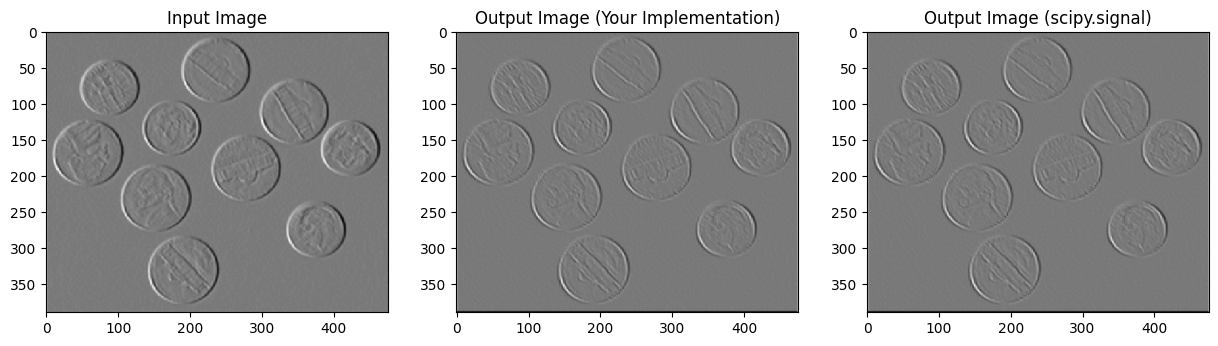

In [62]:
# Below code is to verify your implementation of the convolution
# we compare your output with the scipy.signal implementation of the convolution
# and the error should be zero

# Read the sample image
img = cv2.imread('images/res1.png',0) 

# Generate a random filter F of size 3 x 3
F = np.random.randn(5,3) 

# Perform convolution with the function you implemented
output_1 = applyImageFilter(img, F, padding='same')

# Perform convolution with scipy.signal implementation of convolution
output_2 = conv.convolve2d(img, F , mode='same')

# Error
print(f'Input shape: {img.shape}')
print(f'Output shape: {output_1.shape}')
print(f'Error: {np.sum(np.abs(output_1 - output_2))}')
#check in another way the implementation


# Display the output
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(img)
plt.title('Input Image')
plt.subplot(132)
plt.imshow(output_1)
plt.title('Output Image (Your Implementation)')
plt.subplot(133)
plt.imshow(output_2)
plt.title('Output Image (scipy.signal)')
plt.show()


## Exercise 2: Image Smoothing

Convolutional filters have many uses. A very common one is to smooth or soften an
image. A typical smoothing filter is the Gaussian Filter, which follows the equation of a
2D Gaussian probability distribution. It is an important preprocessing step typically to reduce the amount of noise.  When constructing a Gaussian filter we can specify the size and standard deviation (σ) of the underlying Gaussian function.

* To create a Gaussian filter use the function given below. 

In [89]:
def gaussian_filter(fSize, fSigma):
    x, y = np.mgrid[-fSize//2 + 1:fSize//2 + 1, -fSize//2 + 1:fSize//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*fSigma**2)))
    return g/g.sum()

* What are fSize and fSigma?
* How do fSize and fSigma affect the filter’s shape and size? 
* Visualize different filters by giving different values to these parameters.
* If you are given fSigma, how would you choose fSize?

ANSWERS:
* fSize is the dimension foof the squared filter, fSigma is the standard deviation of the gaussian
* the more fSize is big the biggest is the filter the smootest is the image, the biggest is sigama the more robus is to noise but the more degraded is precision
* if i am given fSigma I decide fSize seeing when the image is well smooth but not to much. if sigma is really big I will not choose a big filter
* Filter visualization:

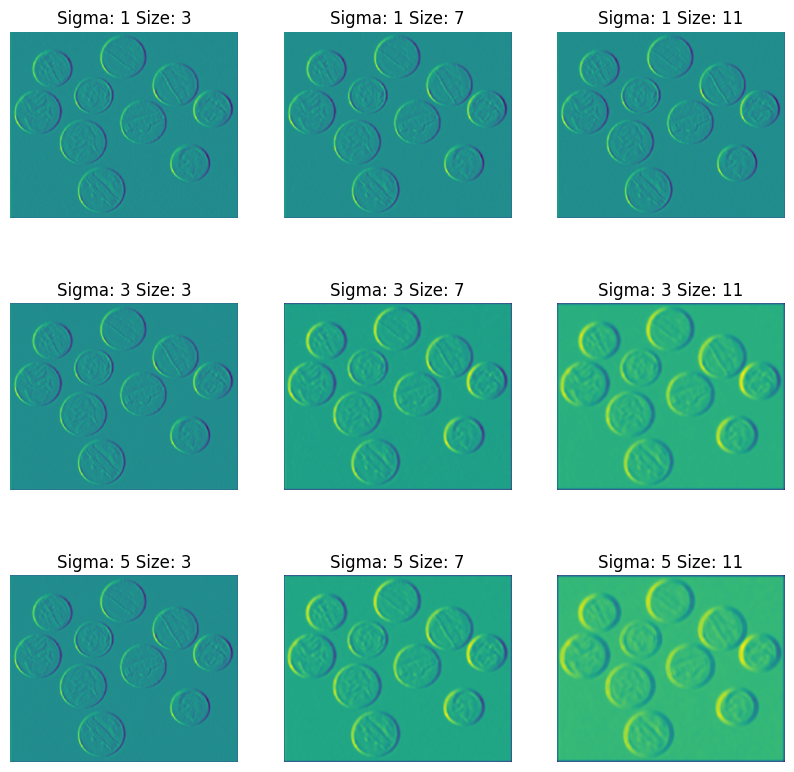

In [90]:
#create subplot for 2 rows and 5 columns
fig, axs = plt.subplots(3, 3)
fSigma= np.array([1, 3, 5])
fSize = np.array([3,7, 11])

for Sigma in range(len(fSigma)):
    for Size in range(len(fSize)):
        F = gaussian_filter(fSize[Size], fSigma[Sigma])
        img = cv2.imread('images/res1.png',0)
        output = applyImageFilter(img, F, padding='same')
        axs[Sigma, Size].imshow(output)
        axs[Sigma, Size].set_title(f'Sigma: {fSigma[Sigma]} Size: {fSize[Size]}')
        axs[Sigma, Size].axis('off')
plt.show()       

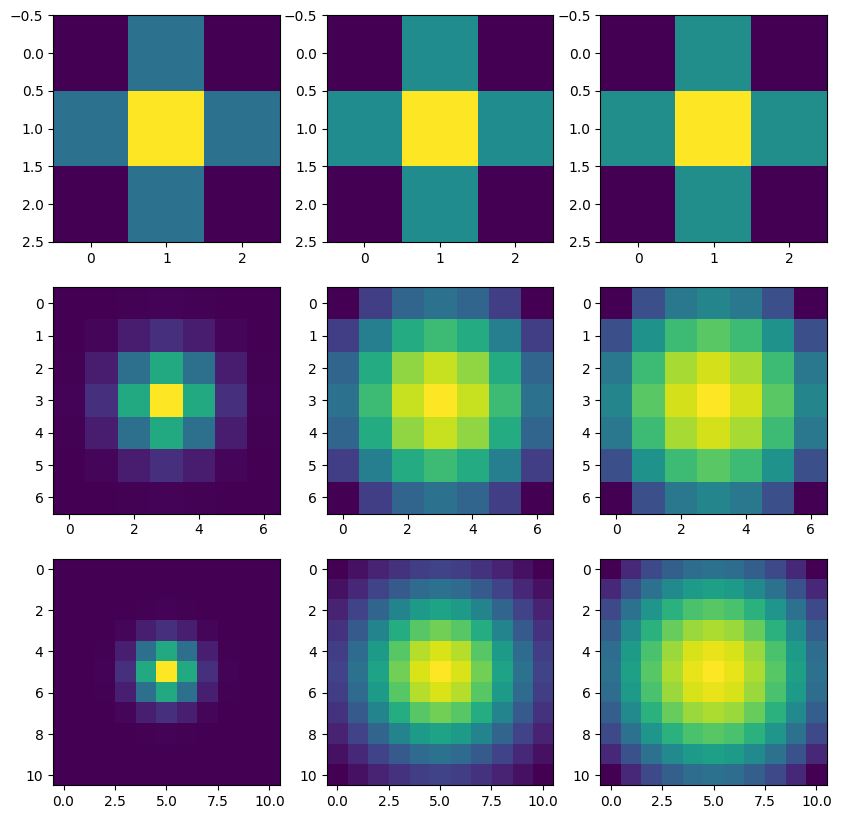

In [92]:
f, axarr = plt.subplots(len(fSize), len(fSigma))
for ind in [(x,y) for x in range(len(fSize)) for y in range(len(fSigma))]:
    axarr[ind].imshow(gaussian_filter(fSize[ind[0]], fSigma[ind[1]]), cmap='viridis')

* Apply Gaussian filtering to 'res1.png'
* To apply the filter to an image use ```cv2.GaussianBlur(img, fSize, fSigma)```
* Experiment with different values of fSigma. How does the amount of smoothing vary with this parameter?

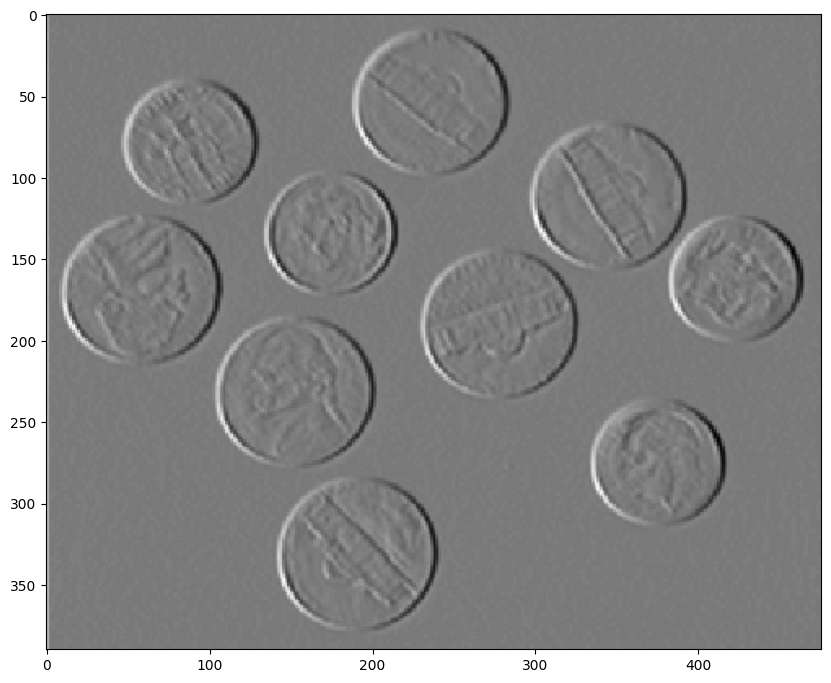

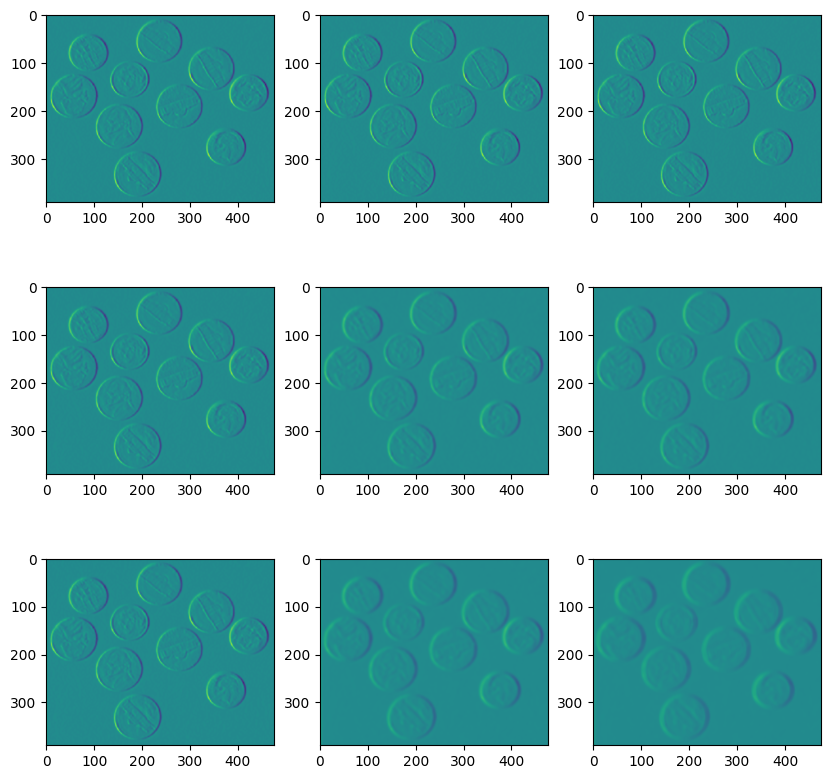

In [93]:
img = cv2.imread('images/res1.png',0)
plt.imshow(img)
sizes = fSize
sigmas = fSigma
f, axarr = plt.subplots(len(sizes), len(sigmas))
for ind in [(x,y) for x in range(len(sizes)) for y in range(len(sigmas))]:
    sz = sizes[ind[0]]
    axarr[ind].imshow(cv2.GaussianBlur(img, (sz, sz), sigmas[ind[1]]), cmap='viridis', vmin = 0, vmax= 255)


As you saw in the first exercise of this session, applying the filter near the border of
the image is not a well-defined problem. It is possible to deal with this issue through
different approaches. Luckily, cv2.GaussianBlur implements different ways of dealing with border effects.
Here you will try them out and understand what each of them does.

*  Apply a Gaussian filter with fSigma = 10 and fSize = 25 to 'res1.png'
* Use borderType flag of cv2.GaussianBlur function to define what kind of border should be added around the image (cv2.BORDER_CONSTANT, cv2.BORDER_REFLECT, cv2.BORDER_REPLICATE).


0
2
1


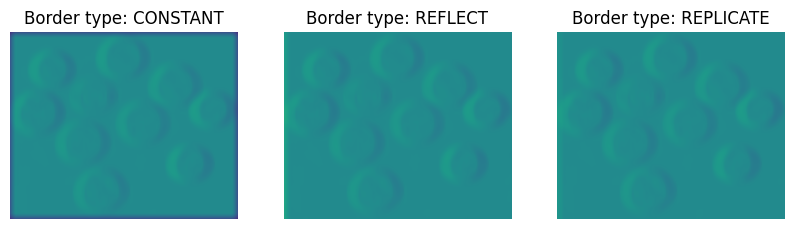

In [105]:
img = cv2.imread('images/res1.png',0)
# apply different border types for blur filters
Borders = [cv2.BORDER_CONSTANT, cv2.BORDER_REFLECT, cv2.BORDER_REPLICATE]
bordernames = ['CONSTANT', 'REFLECT', 'REPLICATE']
f, axarr = plt.subplots(1, 3)
for ind in Borders:
    axarr[ind].imshow(cv2.GaussianBlur(img, (25, 25), 10, borderType=ind), cmap='viridis', vmin = 0, vmax= 255)
    print(ind)
    axarr[ind].set_title(f'Border type: {bordernames[ind]}')
    axarr[ind].axis('off')
plt.show()


## Exercise 3: Edge detector

Edge detection is one of the most important operations in Computer Vision. In this exercise we will investigate how it
can be performed and what information can be obtained from it.

One of the ways to detect edges is to compute image intensity gradients. They can be approximated by convolving image with Sobel filters. They consist of 2 $3 \times 3$ filters:

\begin{equation*}
S_x = \frac{1}{8}
\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1\\
\end{bmatrix}
\hspace{2cm}
S_y = \frac{1}{8}
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
+1 & +2 & +1\\
\end{bmatrix}
\end{equation*}

where $S_x$ computes the partial derivative of the image in the horizontal direction, while $S_y$ does it in the vertical direction.

* Compute the image derivatives in x- and y-directions using Sobel filters. You can use for that function ```python cv2.Sobel()```

In [108]:
img_coins = cv2.imread('images/coins.png',0)

### Compute gradient in x-direction
grad_x = cv2.Sobel(img_coins, cv2.CV_64F, 1, 0, ksize=3)

### Compute gradient in y-direction
grad_y = cv2.Sobel(img_coins, cv2.CV_64F, 0, 1, ksize=3)

* Visualize the image gradients. How can you explain the differences between the two results? 

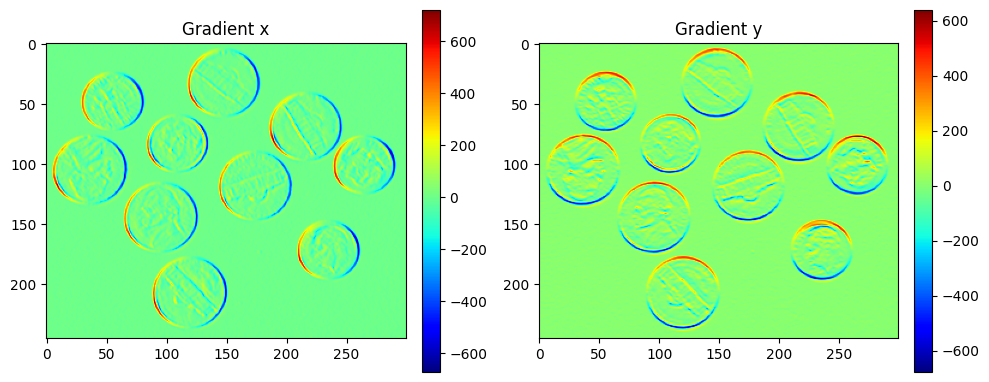

In [109]:
fig = plt.figure()
plt.subplot(1,2,1)
grady = plt.imshow(grad_x,cmap="jet")
plt.title("Gradient x")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,2,2)
gradx = plt.imshow(grad_y,cmap="jet")
plt.title("Gradient y")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

Mathematically, the goal of the filters $S_x$ and $S_y$ is to approximate the derivatives of the image with respect to 
the horizontal and vertical directions respectively, such that
\begin{equation*}
\nabla I_x(x,y) = (I*S_x)[x,y]
\quad\mathrm{and}\quad
\nabla I_y(x,y) = (I*S_y)[x,y]
\end{equation*}

Therefore, the gradient of an image at each point is a 2D vector
\begin{equation*}
\nabla I =
\begin{bmatrix}
\nabla I_x\\
\nabla I_y
\end{bmatrix}
\end{equation*}

This vector can be computed for every pixel. Its magnitude and phase can be computed as
\begin{equation*}
|| \nabla I || = \sqrt{(\nabla I_x)^2 + (\nabla I_y)^2} \\
\angle \nabla I = atan2(\nabla I_x, \nabla I_y)
\end{equation*}

$\it{Note:}$ we use atan2() instead of atan() to be able to determine the right quadrant of the phase.

* Using the previously computed image gradients and the above formula compute the gradient magnitude and gradient phase.



In [112]:
### Compute gradient magnitude
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

### Compute gradient phase
grad_phase = np.arctan2(grad_x, grad_y)

* Visualize the gradient magnitude and phase images along with the original image. Where does the gradient have high 
magnitude? How does the phase change along the coin border?

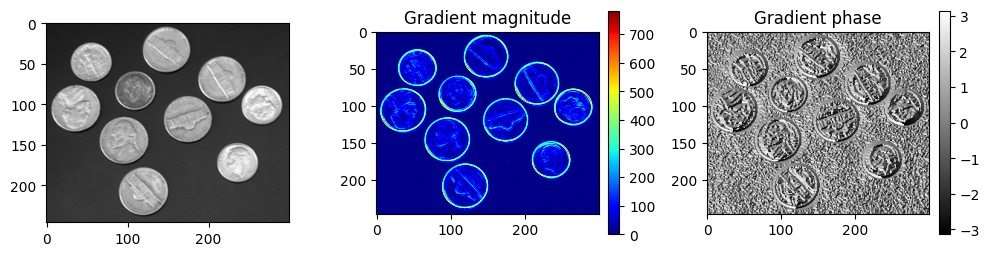

In [113]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(img_coins)
plt.subplot(1,3,2)
grady = plt.imshow(grad_mag,cmap="jet")
plt.title("Gradient magnitude")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,3,3)
gradx = plt.imshow(grad_phase)
plt.title("Gradient phase")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

The gradient has got the highest magnitude at the borders of the coins. For that reason it can be considered a good 
proxy for detecting edges. The phase of the gradient changes smoothly along the circular coin border along with the 
normal of the boundary.

## Exercise 4: Separable Filters


As seen in class, certain types of 2D filters can be thought of as the composition of two
1-dimensional filters. These are called Separable Filters, and can be computed more
efficiently than those who are non-separable.

For example, the Sobel filter $S_x$ can be decomposed as
 
\begin{equation*} 
\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1\\
\end{bmatrix} = 
\begin{bmatrix}
+1 \\
+2 \\
+1 \\
\end{bmatrix}
\begin{bmatrix}
-1 & 0 & +1
\end{bmatrix}
\end{equation*} 

which means that the convolution of I with the 2D filter $S_x$ can be simplified to two
convolutions with 1D filters,

\begin{equation*}  
I * S_x = 
\frac{1}{8} I *
\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1\\
\end{bmatrix}  
\end{equation*} 

\begin{equation*} 
= 
\frac{1}{8}\Bigg(I *
\begin{bmatrix}
+1\\
+2\\
+1\\
\end{bmatrix} \Bigg) *
\begin{bmatrix}
-1 & 0 & +1
\end{bmatrix} 
\end{equation*} 

For the comparison of the computational complexity of separable and non-separable
filters, check out the lecture notes.

* We will compare the performance of separable and non-separable filters.
    -  Create a separable filter (for example a Gaussian filter, you can use  ```gaussian_filter``` function given below) 
    -  Use ```decomposeSeparableFilter``` to decompose the seperable filter to two, 1D filters. 
    -  Implement ```applyImageSepFilter``` function. You can use ```applyImageFilter``` function implemented in Applying Convolutional Filters (Hint: two lines of code)
    -  Performe convolution on ```img``` matrix and measure the time for ```decomposeSeparableFilter``` and ```applyImageSepFilter```. 
    -  Repeat the test with several increasing filter sizes.
    -  measure the elapsed time for each filtering. To get the start and end time, use time.time()
    -  Plot the results in a graph (elapsed time) vs (filter size).
    -  What is your conclusion ? Is filtering with separable filters always faster than with non-separable ones?

In [115]:
def decomposeSeparableFilter(F): 
    h = [1]
    s = len(F)
    for i in range(1,s):
            h.append(np.sum(F[:,i])/(np.sum(F[:,0])))
    h = np.asmatrix(np.array(h))
    v = np.asmatrix(F[:,0]).transpose()
    return v, h

def applyImageSepFilter(I, F_v, F_h):
    # ******************************************
    # Implement the convolution with the two 1D filters and 
    # assign the result to 'output' variable
    # Hint: you only need two lines of code
    # ******************************************
    output = applyImageFilter(applyImageFilter(I, F_v, padding='same'), F_h, padding='same')
    # ******************************************

    return output

In [116]:
# Sample image
img = cv2.imread('images/res1.png',0)
img = img[150:200,150:200] 
# We crop the image, becasue larger images take considerably longer time to 
# perform convolution with large filters
    
# Filter sizes to try out. 
# Since we consider filter with odd heigh and width, 
# we start from 3 and increment it by 2 till 29. 
filter_sizes = range(3,30,2)

In [130]:
# ******************************************
# Perform the comparison here
# Hint: Iterate through the filter_sizes and in each iteration perform convolution with the 2D and 1D filters
#         using applyImageFilter and applyImageSepFilter functions respetively. Measure the time for each execution. 
#         Store the execution times and plot them at the end 
# Note: Performing convolutions with larger filters could take longer time (sometimes more than a minute)
# ******************************************
# 2d time values rows n number as length of filter_size and 2 columns as 1d and 2d
records = [] 
for i in range(len(filter_sizes)):
    print(i)
    filter = gaussian_filter(filter_sizes[i], 1)
    print(filter_sizes[i])
    filter_v, filter_h  = decomposeSeparableFilter(filter)

    start_time = time.time()
    output_separated = applyImageSepFilter(img, filter_v, filter_h)
    twoD_time_filter = time.time() - start_time

    start_time = time.time()
    output = applyImageFilter(img, F, padding='same')
    oneD_time_filter = time.time() - start_time

    error = np.sum(np.abs((output-output_separated)))
    print(f'Filter Size: {str(i):3} error: {error:.3e}')

    records.append([oneD_time_filter, twoD_time_filter])


# ******************************************
    

0
3
Filter Size: 0   error: 3.521e+03
1
5
Filter Size: 1   error: 4.125e+02
2
7
Filter Size: 2   error: 1.617e+01
3
9
Filter Size: 3   error: 2.156e-01
4
11
Filter Size: 4   error: 1.007e-03
5
13
Filter Size: 5   error: 1.688e-06
6
15
Filter Size: 6   error: 1.055e-09
7
17
Filter Size: 7   error: 1.423e-10
8
19
Filter Size: 8   error: 1.183e-10
9
21
Filter Size: 9   error: 1.563e-10
10
23
Filter Size: 10  error: 1.469e-10
11
25
Filter Size: 11  error: 1.120e-10
12
27
Filter Size: 12  error: 1.690e-10
13
29
Filter Size: 13  error: 1.093e-10


Text(0.5, 0, 'Filter size')

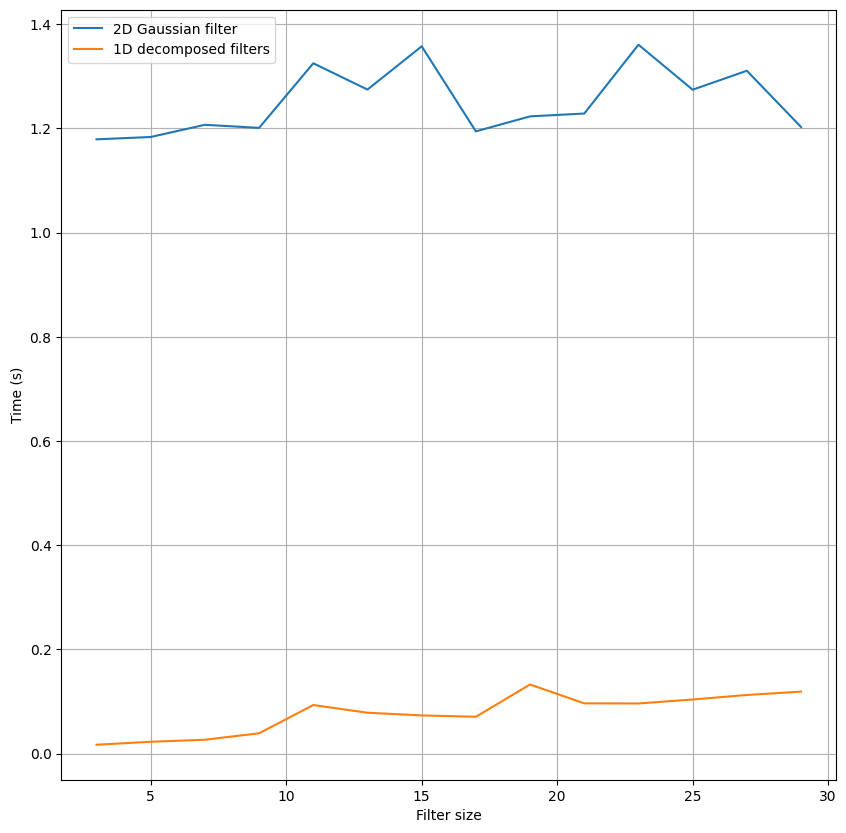

In [131]:
# Plot the comparison here
records = np.array(records)
plt.plot(filter_sizes, records[:,0], label='2D Gaussian filter')
plt.plot(filter_sizes, records[:,1], label='1D decomposed filters')
plt.legend()
plt.grid(True)
plt.ylabel('Time (s)')
plt.xlabel('Filter size')
# ******************************************